## Prognosis of cardiovascular diseases
### Bayesian Logistic Regression with PyMC3

##### Data Visualization in Tableau Public:
https://public.tableau.com/app/profile/anton8444/viz/ThehealthstatusofAmericans2020/Dashboard1

##### Full dataset:
https://www.cdc.gov/brfss/index.html

##### See data preprocessing earlier.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [94]:
df = pd.read_csv('heart_dis_data.csv', dtype = 'float16')

### Combine the 'Heart attack' and 'Stroke' features to define cardiovascular diseases together

In [95]:
df["TARGET"] = df["CVDSTRK3"] + df["_MICHD"]
df = df.replace({'TARGET':{2:1}})

### Make dataset easier

In [96]:
df = df.drop(['AMRNTV', 'WHITE', 'OTHRRACE', 'HISPAN', 'BLACK', 'ASIAN', 'CVDSTRK3', '_MICHD'], axis = 1)
df = df.astype({'TARGET': 'float16'})

### To fix the class imbalance, remove random 87% rows where the target feature is '0'

In [97]:
df.groupby(['TARGET'])['TARGET'].count()

TARGET
0.0    348801
1.0     43142
Name: TARGET, dtype: int64

In [98]:
df = df.drop(df[df['TARGET'] == 0].sample(frac=.87).index )

In [99]:
df.groupby(['TARGET'])['TARGET'].count()

TARGET
0.0    45344
1.0    43142
Name: TARGET, dtype: int64

### The dataset is still huge to RAM with Bayes, remove random 75% of the rows

In [100]:
df = df.sample(frac = .25, random_state = 1)

In [101]:
df.groupby(['TARGET'])['TARGET'].count()

TARGET
0.0    11455
1.0    10667
Name: TARGET, dtype: int64

### View distribution

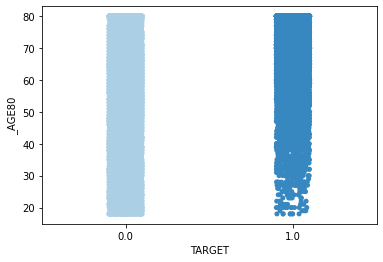

In [102]:
sns.stripplot(x = 'TARGET', y = '_AGE80', data = df, jitter = True, palette = ('Blues'))
plt.show()

### Feature Correlation Overview

<AxesSubplot:>

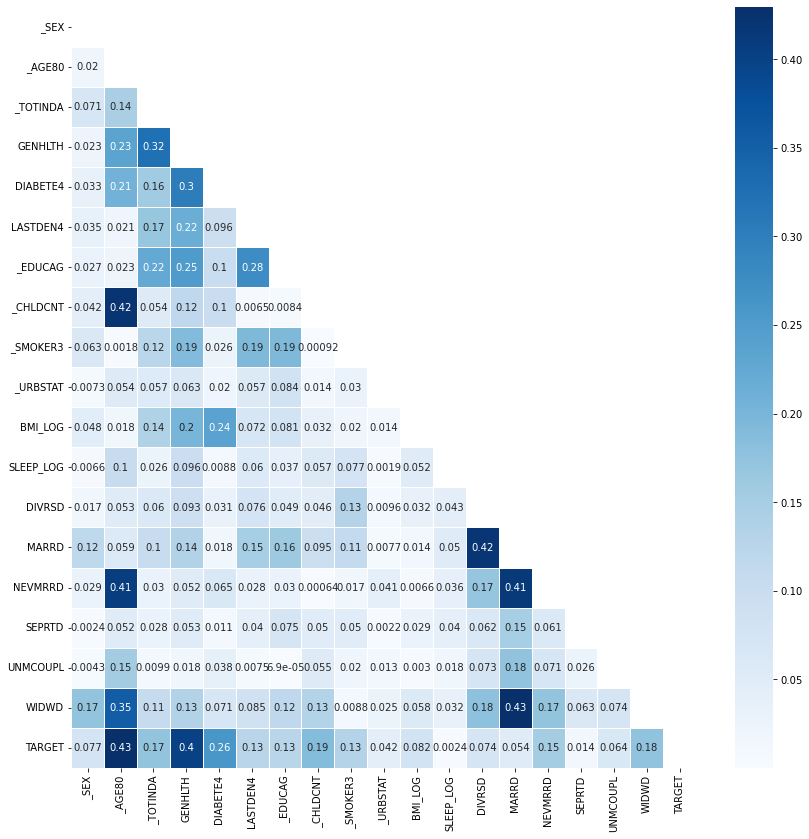

In [104]:
plt.figure(figsize = (14, 14))
corr = df.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask = mask, annot = True, linewidths = .5, fmt = '.2g', cmap = ('Blues'))

The number of children in a family correlates with age, and widowers, divorced and never married correlate with those who are married. Remove number of children, widowers, divorced and never married.

In [23]:
df = df.drop(['_CHLDCNT', 'NEVMRRD', 'DIVRSD', 'WIDWD'  ], axis = 1)
df.columns

Index(['_SEX', '_AGE80', '_TOTINDA', 'GENHLTH', 'DIABETE4', 'LASTDEN4',
       '_EDUCAG', '_SMOKER3', '_URBSTAT', 'BMI_LOG', 'SLEEP_LOG', 'MARRD',
       'SEPRTD', 'UNMCOUPL', 'TARGET'],
      dtype='object')

### Make Bayes Binomial Logistic Regression Model

In [24]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('TARGET ~ _AGE80 + BMI_LOG + _SEX + _TOTINDA + GENHLTH + DIABETE4 + LASTDEN4 + _EDUCAG + _SMOKER3 + _URBSTAT + SLEEP_LOG + MARRD + SEPRTD + UNMCOUPL',
                            df, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [UNMCOUPL, SEPRTD, MARRD, SLEEP_LOG, _URBSTAT, _SMOKER3, _EDUCAG, LASTDEN4, DIABETE4, GENHLTH, _TOTINDA, _SEX, BMI_LOG, _AGE80, Intercept]


/Users/tonyd/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tonyd/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tonyd/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tonyd/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1748 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'_AGE80'}>,
        <AxesSubplot:title={'center':'_AGE80'}>],
       [<AxesSubplot:title={'center':'BMI_LOG'}>,
        <AxesSubplot:title={'center':'BMI_LOG'}>],
       [<AxesSubplot:title={'center':'_SEX'}>,
        <AxesSubplot:title={'center':'_SEX'}>],
       [<AxesSubplot:title={'center':'_TOTINDA'}>,
        <AxesSubplot:title={'center':'_TOTINDA'}>],
       [<AxesSubplot:title={'center':'GENHLTH'}>,
        <AxesSubplot:title={'center':'GENHLTH'}>],
       [<AxesSubplot:title={'center':'DIABETE4'}>,
        <AxesSubplot:title={'center':'DIABETE4'}>],
       [<AxesSubplot:title={'center':'LASTDEN4'}>,
        <AxesSubplot:title={'center':'LASTDEN4'}>],
       [<AxesSubplot:title={'center':'_EDUCAG'}>,
        <AxesSubplot:title={'center':'_EDUCAG'}>],
       [<AxesSubplot:title={'center':'_SMOKER3'}>,
        <AxesSubplot:title={'center':'

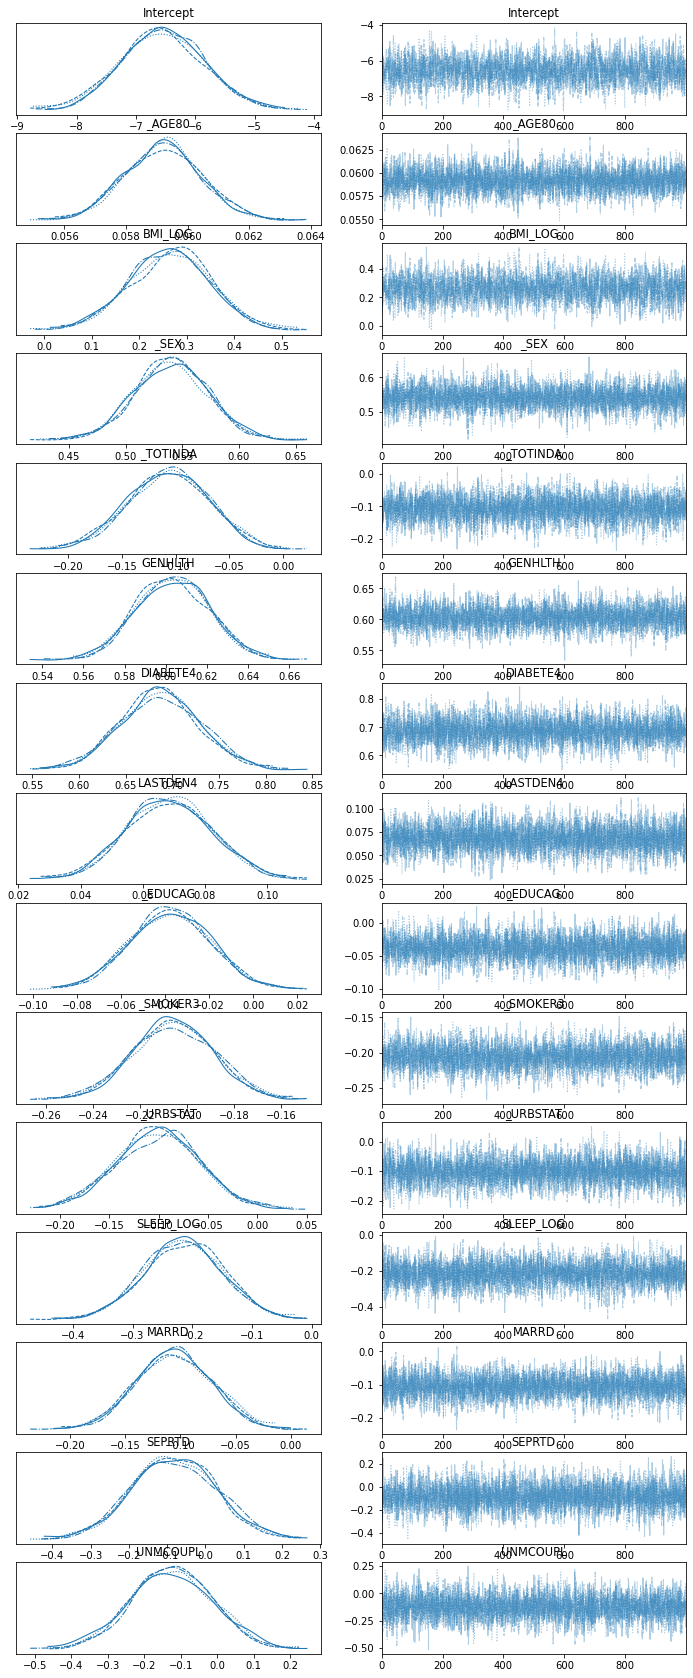

In [79]:
az.plot_trace(trace)

The trace plots are made to make sure that the prior distribution is well calibrated.

### Assessment



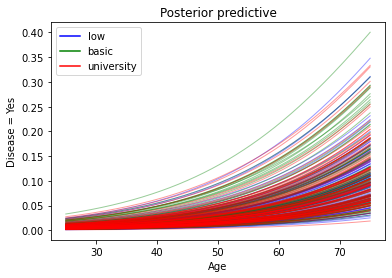

In [26]:
def lm_full(trace, _AGE80, _EDUCAG):
    shape = np.broadcast(_AGE80, _EDUCAG).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [_AGE80, _EDUCAG]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['_AGE80']*x_norm[0] + 
                             trace['_EDUCAG']*x_norm[1] )))

lm = lambda x, samples: lm_full(samples, x, 1 - 0.333252)
lm2 = lambda x, samples: lm_full(samples, x, 0.666992)
lm3 = lambda x, samples: lm_full(samples, x, 1.)

pm.plot_posterior_predictive_glm(trace, eval = np.linspace(25,75,1000), lm = lm, samples = 100, color = 'blue', alpha=.4, lw = 1)
pm.plot_posterior_predictive_glm(trace, eval = np.linspace(25,75,1000), lm = lm2, samples = 100, color = 'green', alpha=.4, lw = 1)
pm.plot_posterior_predictive_glm(trace, eval = np.linspace(25,75,1000), lm = lm3, samples = 100, color = 'red', alpha=.4, lw = 1)

blue_line = mlines.Line2D(['lm'], [], color = 'b', label = 'low')
green_line = mlines.Line2D(['lm2'], [], color = 'g', label = 'basic') 
red_line = mlines.Line2D(['lm3'], [], color = 'r', label = 'university')
plt.legend(handles=[blue_line, green_line, red_line], loc = 2)
plt.ylabel("Disease = Yes")
plt.xlabel("Age")
plt.show()

Each curve shows how the probability of disease having changes with age.

The accumulation of red lines at the bottom suggests that the higher the level of education, the lower the likelihood of cardiovascular disease.

In [28]:
summ_df = pm.summary(trace)
summ_df['odds_ratio'] = np.exp(summ_df['mean'])
summ_df['percentage_effect'] = 100 * (summ_df['odds_ratio'] - 1)
summ_df

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,odds_ratio,percentage_effect
Intercept,-6.554,0.701,-7.944,-5.320,0.015,0.011,2072.0,2612.0,1.0,0.001424,-99.857559
_AGE80,0.059,0.001,0.057,0.062,0.000,0.000,5265.0,2881.0,1.0,1.060775,6.077524
BMI_LOG,0.264,0.085,0.095,0.413,0.002,0.001,2174.0,2621.0,1.0,1.302128,30.212820
_SEX,0.540,0.032,0.480,0.601,0.000,0.000,5613.0,3084.0,1.0,1.716007,71.600686
_TOTINDA,-0.107,0.038,-0.177,-0.035,0.001,0.000,4241.0,2780.0,1.0,0.898526,-10.147433
GENHLTH,0.603,0.017,0.571,0.636,0.000,0.000,4426.0,3116.0,1.0,1.827593,82.759336
DIABETE4,0.687,0.043,0.607,0.767,0.001,0.000,4670.0,3270.0,1.0,1.987743,98.774335
LASTDEN4,0.068,0.014,0.045,0.096,0.000,0.000,5514.0,2985.0,1.0,1.070365,7.036531
_EDUCAG,-0.038,0.018,-0.072,-0.003,0.000,0.000,4686.0,2908.0,1.0,0.962713,-3.728706
_SMOKER3,-0.206,0.017,-0.237,-0.172,0.000,0.000,4072.0,3010.0,1.0,0.813833,-18.616692


With an increase in education by one unit, the probability of having disease decreases by 3,7%. Similarly, as having diabetes increases the probability of disease by 98%, keeping all other independent variables unchanged.

P(0.929 < Odds Ratio < 0.999) = 0.95


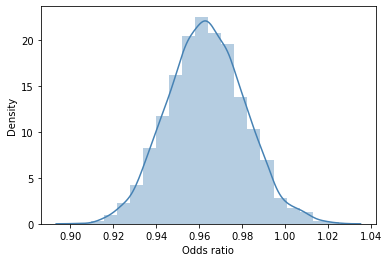

In [89]:
b = trace['_EDUCAG'] 
sns.distplot(np.exp(b), bins = 20, axlabel = 'Odds ratio', color = 'steelblue')
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print('P(%.3f < Odds Ratio < %.3f) = 0.95' % (np.exp(lb), np.exp(ub)))

With a probability of 95%, the odds ratio of the effect of education level on having cardiovascular disease is in the range of 0.929 and 0.999 while keeping all other variables constant.

### Report

##### Bayesian is interpreted as "probabilistic", but if we present the average values of the parameters as the most likely estimate, then we can compare this model with the previous one.

In [30]:
ppc = pm.sample_posterior_predictive(trace, model = logistic_model, samples = 500)
predict = np.rint(ppc['y'].mean(axis = 0)).astype('int')
print('Accuracy of the full model: ', accuracy_score(df['TARGET'], predict))
print('\n Confusion matrix: \n', confusion_matrix(df['TARGET'], predict))
print('\n Reoprt: \n', classification_report(df['TARGET'], predict))

Accuracy of the full model:  0.7520567760600307

 Confusion matrix: 
 [[8436 2930]
 [2555 8201]]

 Reoprt: 
               precision    recall  f1-score   support

         0.0       0.77      0.74      0.75     11366
         1.0       0.74      0.76      0.75     10756

    accuracy                           0.75     22122
   macro avg       0.75      0.75      0.75     22122
weighted avg       0.75      0.75      0.75     22122



##### Despite the reduced dataset Bayesian Logistic Regression with PyMC3 shows a better Accuracy & F1-score than typical machine learning methods.